In [130]:
import pylab as plt
from matplotlib import gridspec
import numpy as np

import treegp
from treegp import AnisotropicRBF
import copy

In [131]:
def get_correlation_length_matrix(size, g1, g2):
    if abs(g1)>1:
        g1 = 0
    if abs(g2)>1:
        g2 = 0
    g = np.sqrt(g1**2 + g2**2)
    q = (1-g) / (1+g)
    phi = 0.5 * np.arctan2(g2,g1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L

# Vanilla Gaussian Process regression using treegp package
# Fancy O(N*log(N)) solver here for hyperparamters using TreeCorr,
# but basic GP regression (Cholesky).
class GaussianProcessTreegp():
    """
    Gaussian Process regression using treegp package.

    This class implements Gaussian Process regression using the treegp package. It provides methods for fitting the
    regression model and making predictions.

    Attributes:
        std (float): The standard deviation parameter for the Gaussian Process kernel.
        l (float): The correlation length parameter for the Gaussian Process kernel.
        white_noise (float): The white noise parameter for the Gaussian Process kernel.
        mean (float): The mean parameter for the Gaussian Process kernel.

    Methods:
        fit(x_good, y_good): Fits the Gaussian Process regression model to the given training data.
        predict(x_bad): Makes predictions using the fitted Gaussian Process regression model.

    """

    def __init__(self, x_good, y_good, y_good_err = None):
        """
        Initializes a new instance of the gp_treegp class.

        Args:
            x_good (array-like): The input features of the training data.
            y_good (array-like): The target values of the training data.
            y_good_err (array-like): The target error values of the training data.

        """
        self.x_good = x_good
        self.y_good = copy.deepcopy(y_good)
        self.y_good_err = copy.deepcopy(y_good_err)
        # norm data for numerical stabilities
        self.norm = np.std(self.y_good)
        self.y_good /= self.norm
        self.y_good_err /= self.norm

    def fit(self):
        """
        Fits the Gaussian Process regression model to the given training data.

        """
        lx = (np.max(self.x_good[:,0]) - np.min(self.x_good[:,0]))
        ly = (np.max(self.x_good[:,1]) - np.min(self.x_good[:,1]))
        l = np.sqrt(lx**2 + ly**2)
        g1 = 0.
        g2 = 0.
        sigma = 1.
        L = get_correlation_length_matrix(l/3., g1, g2)
        inv_L = np.linalg.inv(L)
        KERNEL = "%f"%(sigma**2) + " * AnisotropicRBF(invLam={0!r})".format(inv_L)

        self.gp = treegp.GPInterpolation(
                kernel=KERNEL,
                optimizer="log-likelihood",
                normalize=True,
        )
        self.gp.initialize(self.x_good, self.y_good, y_err=self.y_good_err)
        self.gp.solve()

    def predict(self, x_bad):
        """
        Makes predictions using the fitted Gaussian Process regression model.

        Args:
            x (array-like): The input features for which to make predictions.

        Returns:
            array-like: The predicted target values.

        """
        y_pred = self.gp.predict(x_bad)
        return y_pred * self.norm

In [132]:
data = np.loadtxt('/Users/leget/Downloads/47.txt', delimiter = ",")

In [133]:
x = np.array([data[:,0], data[:,1]]).T
y = data[:,2]
y_err = data[:,3]

In [134]:
tgp = GaussianProcessTreegp(x, y, y_good_err = y_err)
tgp.fit()
y_pred = tgp.predict(x)

(35.2, 74.8, 627.2, 666.8)

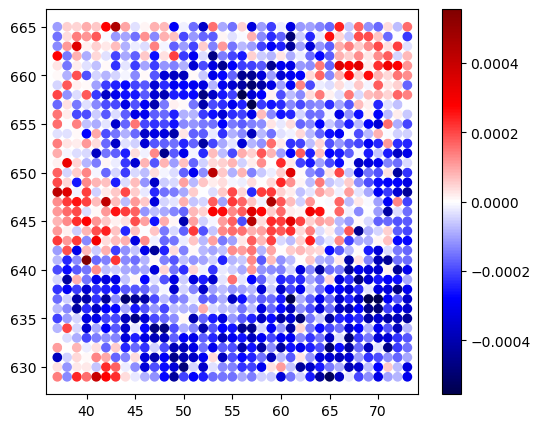

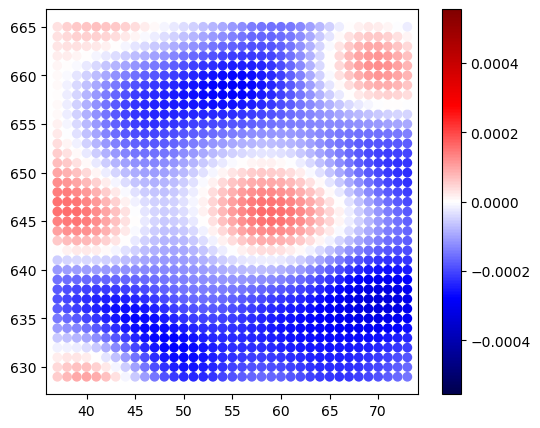

In [135]:
MAX = 3 * np.std(y)

plt.figure(figsize=(6,5))
plt.scatter(x[:,0], x[:,1], c=y, vmin=-MAX, vmax=MAX, cmap=plt.cm.seismic)
plt.colorbar()
plt.axis("equal")

plt.figure(figsize=(6,5))
plt.scatter(x[:,0], x[:,1], c=y_pred, vmin=-MAX, vmax=MAX, cmap=plt.cm.seismic)
plt.colorbar()
plt.axis("equal")